## Tensorflow Tutorial 2: Build First Deep Neurel Network (DNN)

接續著[上一回](http://www.ycc.idv.tw/YCNote/post/38)，我們已經有一個單層的Neurel Network，緊接著我們來試著一步一步改造它，讓它成為我們常使用的Deep Neurel Network的形式。

本單元程式碼可於[Github](https://github.com/GitYCC/Tensorflow_Tutorial/blob/master/code/02_DNN_classification_on_MNIST.py)下載。

In [0]:
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.logging.set_verbosity(tf.logging.ERROR)

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

### 增加Hidden Layer

在上一回當中，我們只有一層Neurel Network，也就是做完一個線性轉換後，就直接使用Softmax Layer來轉換成機率表示方式，這樣的結構並不夠powerful，我們需要把它的結構弄的又窄又深，這樣效果才會好，詳細原因請參考[這一篇的介紹](http://www.ycc.idv.tw/YCNote/post/35)。

因此，我們來試著加入一層Hidden Layer，來打造成兩層的Neurel Network，並在兩層之間加入Activation Function，為我的Model增加非線性因子。

In [0]:
def structure(self, features, labels, n_hidden, activation, dropout_ratio=0, train=False):
    # build neurel network structure and return their predictions and loss
    ### Variable
    if (not self.weights) or (not self.biases):
        self.weights = {
            'fc1': tf.Variable(tf.truncated_normal(shape=(self.n_features, n_hidden))),
            'fc2': tf.Variable(tf.truncated_normal(shape=(n_hidden, self.n_labels))),
        }
        self.biases = {
            'fc1': tf.Variable(tf.zeros(shape=(n_hidden))),
            'fc2': tf.Variable(tf.zeros(shape=(self.n_labels))),
        }
    ### Structure
    # layer 1
    fc1 = self.getDenseLayer(features, self.weights['fc1'],
                                       self.biases['fc1'], activation=activation)
    if train:
        fc1 = tf.nn.dropout(fc1, keep_prob=1-dropout_ratio)

    # layer 2
    logits = self.getDenseLayer(fc1, self.weights['fc2'], self.biases['fc2'])

    y_ = tf.nn.softmax(logits)

    loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))

    return (y_, loss)

首先在變數需要有二層的fully-connect參數，注意這些參數的大小，受到Hidden Layer的神經元數目`n_hidden`決定。接下來開始建構整個Neurel Network的結構，`fc1`產生一個fully-connect的結果，並且通過Activation Function再輸出，然後進到下一層，第二層直接使用`fc1`的結果當作新的輸入，再做一次fully-connect，並且讓它通過Softmax Layer來完成最後的Logistic轉換，它的loss一樣的是使用cross-entropy來評估。

### Activation Function的選擇

剛剛提到的Hidden Layer可以採用不同的Activation Function，我列幾個常使用的Activation Function給大家看看。

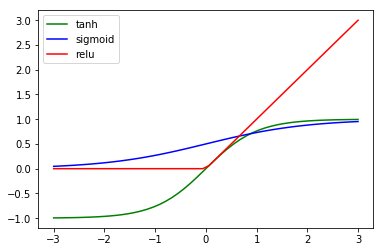

In [3]:
with tf.Session() as sess:
    x = np.linspace(-3, 3)
    tanh = tf.nn.tanh(x).eval()
    sigmoid = tf.nn.sigmoid(x).eval()
    relu = tf.nn.relu(x).eval()
    
    plt.plot(x,tanh, 'g', x,sigmoid, 'b', x,relu, 'r')
    plt.legend(('tanh',  'sigmoid',  'relu'))
    plt.show()

這些Activation Function的使用時機可以簡單這樣說，當我們想要輸出值在+1和-1之間時使用tanh，而當我們想要一個輸出值衡為正時使用sigmoid，它可以將輸出值壓在+1和0之間。tanh比sigmoid多了兩個好處，第一，tanh的梯度變化大於sigmoid，有利於訓練效率，第二，tanh的輸出均值為0，可以避免將前層的梯度偏差帶到下一層。

不過，以上的這兩種Activation Function在非常深的網路都會有一個共通問題—梯度消失，仔細看上圖，tanh和sigmoid在極大和極小的地方都會彎成平的，所以每過一次這種Activation Function，訊號就會減小一點，當我們在深網路做Backpropagation時，訊號在過程中不斷的被磨損，到了前面的幾層就已經耗損完畢，此時更新的梯度近乎0，也就是梯度消失，那麼前面的這些層就再也訓練不到了。

Relu正可以解決梯度消失的問題，如上圖，在正的部分Relu是線性的，所以多少訊號進來就多少訊號出去，如此一來就不會有耗損的問題，但特別注意，因為tanh和sigmoid會將輸出值限制在一個範圍內，所以有Normalization的味道，但是Relu沒有限制，Normalization可以使我們訓練的效率提升（因為梯度的方向可以直指低點），所以Relu常常會搭配Normalization Layer一起使用，來額外做Normalization，或者是最近一篇Paper提到的一種新的Activation Function：SELU，類似於Relu但是輸出值會是Normalize過的，非常神奇，在這邊我不多論述。

### Mini-Batch Gradient Descent

在上一回當中，我們的Gradient Descent採用的是將所有的Data一次全考慮進去，評估完所有的Data在一次性的更新權重參數，這樣的作法好處是比較穩定，因為我考慮的是真正的Training Set的$E_{in}$，但缺點就是計算時間長，因為要考慮所有Training Set的每筆數據，需要做大矩陣的計算，而且通常Training Set的數據量也不可以太小，這麼一來計算時間就會拉的很長。

因此，有另外一種作法一次只考慮「一筆」數據，使用一筆數據來評估並更新權重參數，每一筆雖然更新結果都不怎麼準確，但是當我隨著時間看過整個Training Set後，就會有平均的效果，所以最後只要Learning Rate不要太大，最後的結果還是可以朝向最佳解的，這個手法會使得Gradient Descent具有隨機性，因此又被稱為Stochastic Gradient Descent，它所帶來的優點是計算時間變短了，我們將可以避免去涉及大矩陣的運算，但缺點是一次只評估一筆數據，將會非常的不穩定。

另外還有一種介於Gradient Descent和Stochastic Gradient Descent之間的作法，稱之為Mini-Batch Gradient Descent，它不像Stochastic Gradient Descent那麼極端，一次只評估一組Data，Mini-Batch Gradient Descent一次評估k組數據，並更新參數W，這是相當好的折衷方案，平衡計算時間和更新穩定度，而且在某些情形下，計算時間還比Stochastic Gradient Descent還快，為什麼呢？GPU的架構設計是非常有利於矩陣計算的，因為GPU會利用它強大的平行化將矩陣運算中每個元素平行計算，可以大大增進效率，所以如果一次只算一筆資料，反而是沒有利用到GPU的效率，所以如果你用GPU計算的話，依照你的GPU去設計適當的k值做Mini-Batch Gradient Descent，這個k值不要超過GPU平行計算所能容納的最大上限，這是個既有效率又更為穩定的作法，順道一提Tensorflow是可以支援GPU的計算的。

實務經驗告訴我們Mini-Batch Gradient Descent雖然穩定性比Gradient Descent差，但是收斂的速度卻一點都不輸給Gradient Descent，原因就出在更新的次數，Mini-Batch Gradient Descent一次看的數據筆數比較少，所以Mini-Batch一個Epoch可以更新參數好幾次，而Gradient Descent卻只能更新一次，Mini-Batch的靈敏性，使得它的收斂速度更為快速。打個比方，就好像是兩艘船在搜尋小島，Gradient Descent像是巡洋艦，它有更好設備可以有更好的觀測能力，但是因為它的笨重造成它反應不夠靈敏，Mini-Batch Gradient Descent就像是小船一樣，雖然觀測設備沒這麼好，但是反應靈敏，卻是可以更容易率先找到小島。

那我們來看看要怎麼做到Mini-Batch Gradient Descent。

In [0]:
def fit(self, X, y, epochs=10, validation_data=None, test_data=None, batch_size=None):
    ...略...

    self.sess.run(self.init_op)
    for epoch in range(epochs):
        print('Epoch %2d/%2d: ' % (epoch+1, epochs))

        # mini-batch gradient descent
        index = [i for i in range(N)]
        random.shuffle(index)
        while len(index) > 0:
            index_size = len(index)
            batch_index = [index.pop() for _ in range(min(batch_size, index_size))]

            feed_dict = {
                self.train_features: X[batch_index, :],
                self.train_labels: y[batch_index],
            }
            _, loss = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)

            print('[%d/%d] loss = %9.4f     ' % (N-len(index), N, loss), end='\r')

        ...略...

在每一個`epoch`都完整的看過數據一遍，而mini-batch gradient descent是隨機取`batch_size`筆數據來更新權重，所以我採用這樣的作法，先依照數據的筆數`N`列出可能的Index有哪些，然後再做一個`random.shuffle`來做到隨機採樣，然後接下來只要簡單的從前面取`batch_size`筆數據進行更新，直到用盡所有的index為止，就可以做到mini-batch的效果。

### Regularization

當你開始加深你的DNN時，就已經在增加Model的複雜度，增加複雜度想當然爾的可以增加對於數據的描述能力，在分類問題中代表可以增加精確度，不過要特別注意Overfitting的出現，當Model越複雜越容易產生Overfitting，Overfitting的結果是有看過的數據描述的很好，但沒看過的數據預測就很差，所以在Training的過程要特別注意Validation Set的表現，如果發現Training Set的表現越來越好，但是Validation Set的表現裹足不前甚至變的更差，那就很有可能已經Overfitting了。

如果你已經看到Overfitting出現了，有什麼方法可以抑制他呢？這個時候就需要Regularization的幫忙，在Neurel Network常見的Regularization有兩種：Weight Regularization和Dropout，待會會一一介紹。

這邊特別注意，不要每次精確度沒有提升就怪Overfitting！如果連你的Training Set都沒辦法有好的表現，這就可能不是Overfitting，反而可能是Underfitting，這個時候不要再增加Regularization，而是試著去調整Learning Rate，或者增加模型的複雜度，加深DNN或增加神經元的數目。

### Weight Regularization

我們可以藉著在Loss Function裡頭加入Weight的貢獻，來達到限制W的大小的目標，這樣做可以降低Overfitting，詳細原理請[參考這篇的Regularization的部分](http://www.ycc.idv.tw/YCNote/post/28)。

我們來看看應該怎麼做到L2 Regularization。

In [0]:
# regularization loss
regularization = tf.reduce_mean([tf.nn.l2_loss(w) / tf.size(w, out_type=tf.float32) for w in self.weights.values()])
# total loss
loss = original_loss + alpha * regularization

在這裡我習慣將Loss對Weights的個數做平均，這有一個好處當我在調整神經元數目時，`alpha`可以不需要大動作調整。

### Dropout

Dropout是Deep Learning常用的Regularization技巧，它的作法是在訓練的時候我先隨機把部份的神經元關閉，使用較少的神經元訓練，來達到Regularization的效果，最後在「推論」的時候再使用全部的神經元，我個人覺得這有Aggregation Model的味道，分別訓練出許多的sub-model再做Aggregation以達到截長補短的效果。

實作上有一些細節必須要注意，當我們關閉一些神經元時，也就是等於減少部份的貢獻量，所以我們需要依照相應比例來給予權重，以抵銷減少的部分。舉個例子，假設今天原本應該要輸出的值有十個，這十個值都是1，然後因為Dropout，變成五個1五個0的輸出，我們看到原本貢獻量因為Dropout一半而少一半，這樣並不合理，會導致我後面的Weights在更新的時候低估更新量，所以我們必須要將「沒被Dropout的部分」權重乘上一倍，才可以解決問題。因此，如果Dropout $r$倍的神經元，權重就要乘以$(1/r)$倍，我們來看看Tensorflow怎麼做的。

In [4]:
with tf.Session() as sess:
    S = tf.constant([[1, 1, 1, 1, 1, 1, 1, 1],
                           [3, 3, 3, 3, 3, 3, 3, 3],
                           [5, 5, 5, 5, 5, 5, 5, 5]],tf.float32)  # 3 Data, 8 dim. Score
    print('Original S =')
    print(S.eval())
    S_drop = tf.nn.dropout(S,keep_prob=0.5)  # dropout ratio = 1 - keep_prob = 0.5
    print('Dropout S =')
    print(S_drop.eval())

Original S =
[[1. 1. 1. 1. 1. 1. 1. 1.]
 [3. 3. 3. 3. 3. 3. 3. 3.]
 [5. 5. 5. 5. 5. 5. 5. 5.]]
Dropout S =
[[ 2.  0.  0.  2.  0.  0.  2.  0.]
 [ 0.  0.  6.  0.  0.  6.  0.  6.]
 [10. 10. 10.  0. 10. 10. 10. 10.]]


我們看到因為dropout 0.5倍，所以輸出值權重乘上2倍，另外一提，Tensorflow的Dropout機制是隨機的，所以Drop out的比例會接近我們想要的比例，但不是絕對剛好。

那我要怎麼把Dropout放進去我的Model呢？特別注意，我們並不希望已經Training完的Model還有Dropout這一層，所以我在`structure`裡頭設計一個`train`的開關，當我在Training過程就把它打開，Dropout這一層就會被加進去，「推論」的時候就關閉，保持原有的神經元數量。

In [0]:
    def structure(self,features,labels,n_hidden,activation,dropout_ratio=0,train=False):
        
        ... 略 ...
        
        # layer 1
        fc1 = self.getDenseLayer(features,self.weights['fc1'], self.biases['fc1'], activation=activation)
        if train:
            fc1 = tf.nn.dropout(fc1, keep_prob=1-dropout_ratio)
            
        # layer 2
        logits = self.getDenseLayer(fc1, self.weights['fc2'], self.biases['fc2'])
        
        ... 略 ...

### Optimizer的選擇

我們可以自由的替換我們想要使用的Optimizer。

In [0]:
# define training operation
optimizer = tf.train.AdamOptimizer(learning_rate)
self.train_op = optimizer.minimize(self.loss)

在Tensorflow中目前有以下十種Optimizer供我們使用。

* tf.train.GradientDescentOptimizer
* tf.train.AdadeltaOptimizer
* tf.train.AdagradOptimizer
* tf.train.AdagradDAOptimizer
* tf.train.MomentumOptimizer
* tf.train.AdamOptimizer
* tf.train.FtrlOptimizer
* tf.train.ProximalGradientDescentOptimizer
* tf.train.ProximalAdagradOptimizer
* tf.train.RMSPropOptimizer

如果想要了解每個Optimizer的演算法可以參考[這篇有詳細的說明](http://ruder.io/optimizing-gradient-descent/)。

### 來看看程式怎麼寫

講了那麼多，來看看完整的程式怎麼寫？照慣例，先畫個流程圖。

![DNNLogisticClassification](https://raw.githubusercontent.com/GitYCC/Tensorflow_Tutorial/master/img/TensorflowTutorial.003.jpeg)

In [0]:
class DNNLogisticClassification:

    def __init__(self, n_features, n_labels,
                 learning_rate=0.5, n_hidden=1000, activation=tf.nn.relu,
                 dropout_ratio=0.5, alpha=0.0):

        self.n_features = n_features
        self.n_labels = n_labels

        self.weights = None
        self.biases = None

        self.graph = tf.Graph()  # initialize new graph
        self.build(learning_rate, n_hidden, activation,
                   dropout_ratio, alpha)  # building graph
        self.sess = tf.Session(graph=self.graph)  # create session by the graph

    def build(self, learning_rate, n_hidden, activation, dropout_ratio, alpha):
        # Building Graph
        with self.graph.as_default():
            ### Input
            self.train_features = tf.placeholder(tf.float32, shape=(None, self.n_features))
            self.train_labels = tf.placeholder(tf.int32, shape=(None, self.n_labels))

            ### Optimalization
            # build neurel network structure and get their predictions and loss
            self.y_, self.original_loss = self.structure(features=self.train_features,
                                                         labels=self.train_labels,
                                                         n_hidden=n_hidden,
                                                         activation=activation,
                                                         dropout_ratio=dropout_ratio,
                                                         train=True)
            # regularization loss
            self.regularization = \
                tf.reduce_sum([tf.nn.l2_loss(w) for w in self.weights.values()]) \
                / tf.reduce_sum([tf.size(w, out_type=tf.float32) for w in self.weights.values()])

            # total loss
            self.loss = self.original_loss + alpha * self.regularization

            # define training operation
            optimizer = tf.train.GradientDescentOptimizer(learning_rate)
            self.train_op = optimizer.minimize(self.loss)

            ### Prediction
            self.new_features = tf.placeholder(tf.float32, shape=(None, self.n_features))
            self.new_labels = tf.placeholder(tf.int32, shape=(None, self.n_labels))
            self.new_y_, self.new_original_loss = self.structure(features=self.new_features,
                                                                 labels=self.new_labels,
                                                                 n_hidden=n_hidden,
                                                                 activation=activation)
            self.new_loss = self.new_original_loss + alpha * self.regularization

            ### Initialization
            self.init_op = tf.global_variables_initializer()

    def structure(self, features, labels, n_hidden, activation, dropout_ratio=0, train=False):
        # build neurel network structure and return their predictions and loss
        ### Variable
        if (not self.weights) or (not self.biases):
            self.weights = {
                'fc1': tf.Variable(tf.truncated_normal(shape=(self.n_features, n_hidden))),
                'fc2': tf.Variable(tf.truncated_normal(shape=(n_hidden, self.n_labels))),
            }
            self.biases = {
                'fc1': tf.Variable(tf.zeros(shape=(n_hidden))),
                'fc2': tf.Variable(tf.zeros(shape=(self.n_labels))),
            }
        ### Structure
        # layer 1
        fc1 = self.get_dense_layer(features, self.weights['fc1'],
                                   self.biases['fc1'], activation=activation)
        if train:
            fc1 = tf.nn.dropout(fc1, keep_prob=1-dropout_ratio)

        # layer 2
        logits = self.get_dense_layer(fc1, self.weights['fc2'], self.biases['fc2'])

        y_ = tf.nn.softmax(logits)

        loss = tf.reduce_mean(
                 tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))

        return (y_, loss)

    def get_dense_layer(self, input_layer, weight, bias, activation=None):
        # fully connected layer
        x = tf.add(tf.matmul(input_layer, weight), bias)
        if activation:
            x = activation(x)
        return x

    def fit(self, X, y, epochs=10, validation_data=None, test_data=None, batch_size=None):
        X = self._check_array(X)
        y = self._check_array(y)

        N = X.shape[0]
        random.seed(9000)
        if not batch_size:
            batch_size = N

        self.sess.run(self.init_op)
        for epoch in range(epochs):
            print('Epoch %2d/%2d: ' % (epoch+1, epochs))

            # mini-batch gradient descent
            index = [i for i in range(N)]
            random.shuffle(index)
            while len(index) > 0:
                index_size = len(index)
                batch_index = [index.pop() for _ in range(min(batch_size, index_size))]

                feed_dict = {
                    self.train_features: X[batch_index, :],
                    self.train_labels: y[batch_index],
                }
                _, loss = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)

                print('[%d/%d] loss = %9.4f     ' % (N-len(index), N, loss), end='\r')

            # evaluate at the end of this epoch
            y_ = self.predict(X)
            train_loss = self.evaluate(X, y)
            train_acc = self.accuracy(y_, y)
            msg = '[%d/%d] loss = %8.4f, acc = %3.2f%%' % (N, N, train_loss, train_acc*100)

            if validation_data:
                val_loss = self.evaluate(validation_data[0], validation_data[1])
                val_acc = self.accuracy(self.predict(validation_data[0]), validation_data[1])
                msg += ', val_loss = %8.4f, val_acc = %3.2f%%' % (val_loss, val_acc*100)

            print(msg)

        if test_data:
            test_acc = self.accuracy(self.predict(test_data[0]), test_data[1])
            print('test_acc = %3.2f%%' % (test_acc*100))

    def accuracy(self, predictions, labels):
        return (np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/predictions.shape[0])

    def predict(self, X):
        X = self._check_array(X)
        return self.sess.run(self.new_y_, feed_dict={self.new_features: X})

    def evaluate(self, X, y):
        X = self._check_array(X)
        y = self._check_array(y)
        return self.sess.run(self.new_loss, feed_dict={self.new_features: X,
                                                       self.new_labels: y})

    def _check_array(self, ndarray):
        ndarray = np.array(ndarray)
        if len(ndarray.shape) == 1:
            ndarray = np.reshape(ndarray, (1, ndarray.shape[0]))
        return ndarray

In [6]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

train_data = mnist.train
valid_data = mnist.validation
test_data = mnist.test

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
model = DNNLogisticClassification(
    n_features=28*28,
    n_labels=10,
    learning_rate=0.5,
    n_hidden=1000,
    activation=tf.nn.relu,
    dropout_ratio=0.5,
    alpha=0.01,
)
model.fit(
    X=train_data.images,
    y=train_data.labels,
    epochs=3,
    validation_data=(valid_data.images, valid_data.labels),
    test_data=(test_data.images, test_data.labels),
    batch_size = 32,
)

Epoch  1/ 3: 
[55000/55000] loss =   0.4948, acc = 88.12%, val_loss =   0.5729, val_acc = 88.14%
Epoch  2/ 3: 
[55000/55000] loss =   0.3343, acc = 91.21%, val_loss =   0.3831, val_acc = 91.04%
Epoch  3/ 3: 
[55000/55000] loss =   0.2890, acc = 92.73%, val_loss =   0.3708, val_acc = 92.06%
test_acc = 91.17%


跟上次的結果比，你會發現有長足的進步，精確率來到90幾，大家可以[下載程式碼](https://github.com/GitYCC/Tensorflow_Tutorial/blob/master/code/02_DNN_classification_on_MNIST.py)，試著調整參數使得DNN Model的精確率可以更高，參數包含：
* Hidden Layer的神經元數量
* 不同的Activation Function
* 不同的Batch Size
* 調整Weight Regularization的比例
* 調整Dropout Ratio
* 選擇不同Optimizer
* 使得DNN更深

調整Model是重要的工作，試著自己動手做做看，你可以讓你的Model有多準呢？